# Fast gradient sign method

FGSM is a simple technique for generating adversarial examples by perturbing the input image in the direction of the gradient of the loss function with respect to the input. The goal is to mislead the model into making an incorrect prediction.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
# Setting seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(69)


In [3]:
#Getting lables of Imagenet
!wget -q https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [4]:
model = models.resnet18(pretrained=True).eval()

with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Classifying the image

In [6]:
url = "https://pethelpful.com/.image/w_3840,q_auto:good,c_fill,ar_4:3/MjAwMzg3MjgzOTk0NjE3MjA4/doberman-pinscher-guide.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")



input_tensor = transform(image).unsqueeze(0)



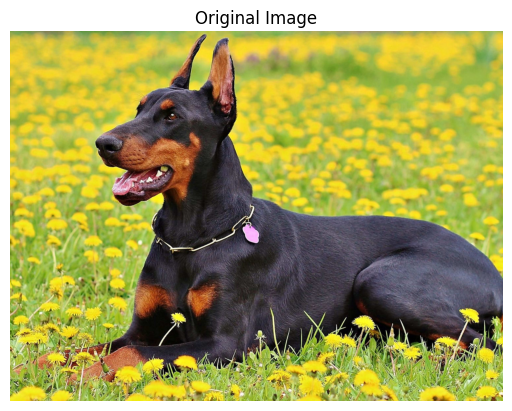

In [7]:
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [8]:
with torch.no_grad():
    output = model(input_tensor)
    orig_idx = output.argmax(dim=1).item()
    print(f"Original Prediction: {labels[orig_idx]}")


Original Prediction: Doberman


### FGSM attack

In [9]:
def fgsm_attack(model, image, label_idx, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, torch.tensor([label_idx]))

    model.zero_grad()
    loss.backward()
    perturbed = image + epsilon * image.grad.data.sign()
    perturbed = torch.clamp(perturbed, -1, 1)
    return perturbed


In [10]:
epsilon = 0.09
adv_image = fgsm_attack(model, input_tensor.clone(), orig_idx, epsilon)

with torch.no_grad():
    adv_output = model(adv_image)
    adv_idx = adv_output.argmax(dim=1).item()

print(f"Adversarial Prediction: {labels[adv_idx]}")


Adversarial Prediction: Gordon setter


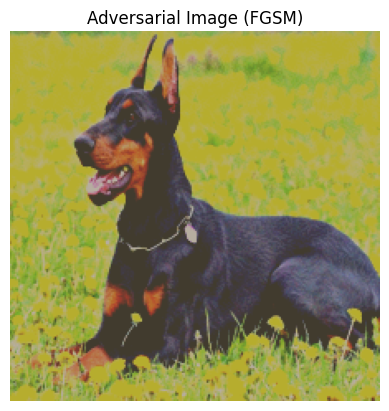

In [11]:
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    return torch.clamp(tensor * std + mean, -1, 1)

# Visualize adversarial image
adv_img = denormalize(adv_image.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
plt.imshow(adv_img.permute(1, 2, 0).detach().numpy())
plt.title("Adversarial Image (FGSM)")
plt.axis('off')
plt.show()


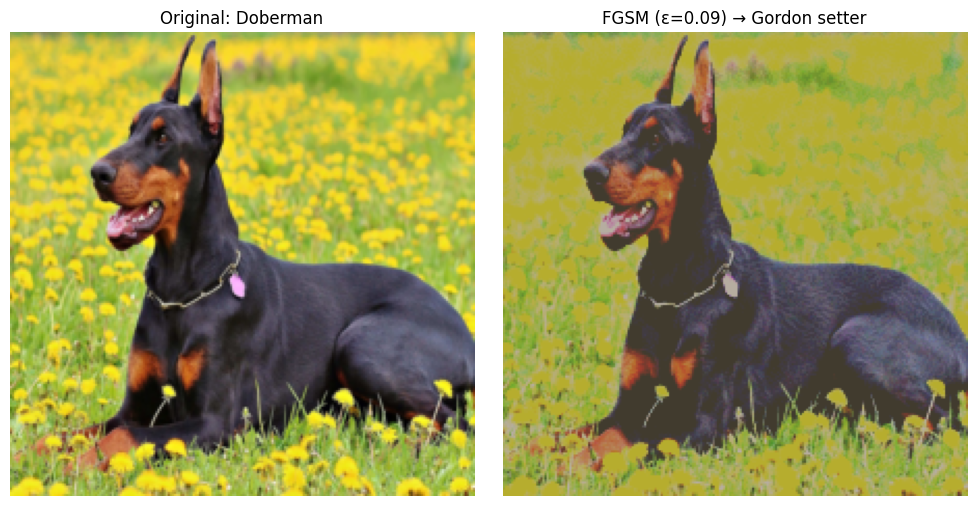

In [12]:
def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return torch.clamp(t * std + mean, -1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(denormalize(input_tensor.squeeze()).permute(1, 2, 0).numpy())
axs[0].set_title(f"Original: {labels[orig_idx]}")
axs[0].axis('off')

axs[1].imshow(denormalize(adv_image.squeeze()).permute(1, 2, 0).detach().numpy())
axs[1].set_title(f"FGSM (ε={epsilon}) → {labels[adv_idx]}")
axs[1].axis('off')
plt.tight_layout()
plt.show()


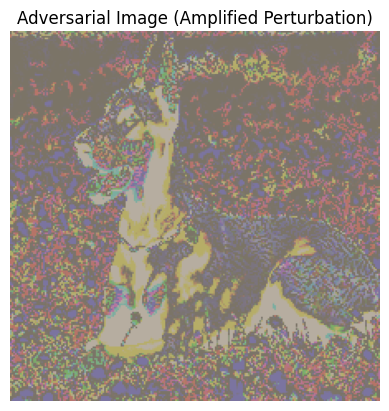

In [13]:
amplified = (adv_image - input_tensor) * 10
visual = torch.clamp(input_tensor + amplified, 0, 1)
visual = denormalize(visual.squeeze())

plt.imshow(visual.permute(1, 2, 0).detach().cpu().numpy())
plt.title("Adversarial Image (Amplified Perturbation)")
plt.axis('off')
plt.show()


 Amplified pertubation visualizes the adversarial change by exaggerating the pixel difference 10 times. Shows where the image was altered and how FGSM targets specific regions.

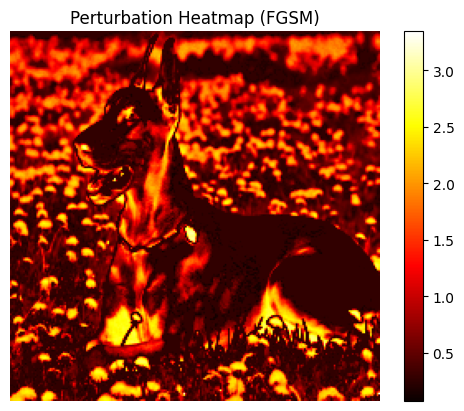

In [14]:
diff = (adv_image - input_tensor).squeeze().abs().sum(0)
plt.imshow(diff.cpu().detach().numpy(), cmap='hot')
plt.title("Perturbation Heatmap (FGSM)")
plt.axis('off')
plt.colorbar()
plt.show()


The perttubation heatmap shows which parts of the image were most affected by the FGSM attack. Brighter areas represent higher pixel-wise changes. It helps us to localize attack impact.

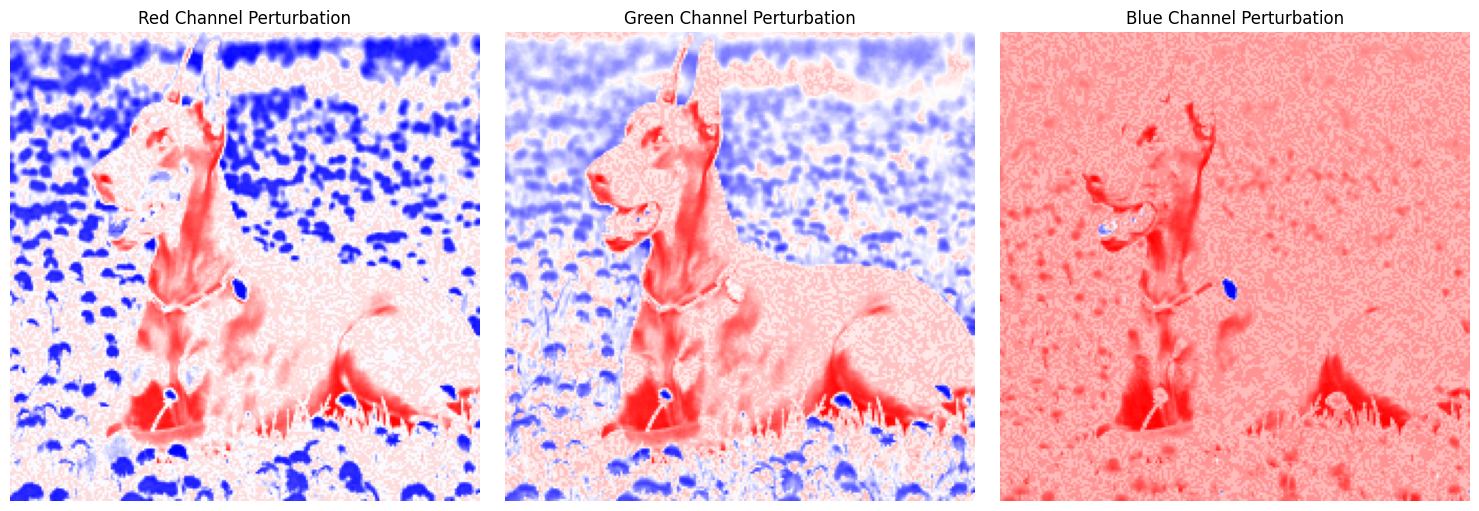

In [15]:
diff_normalized = (adv_image - input_tensor).squeeze().detach()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    axs[i].imshow(diff_normalized[i].cpu().numpy(), cmap='bwr')
    axs[i].set_title(f'{color} Channel Perturbation')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


Per-channel pertubation shows the FGSM changes in Red, Green, and Blue channels separately. It helps us to understand which color channels were targeted most during the attack. Blue => negative, red => positive

### Taking larger epsilion

In [16]:
epsilon = 0.6
adv_image = fgsm_attack(model, input_tensor.clone(), orig_idx, epsilon)

with torch.no_grad():
    adv_output = model(adv_image)
    adv_idx = adv_output.argmax(dim=1).item()

print(f"Adversarial Prediction: {labels[adv_idx]}")


Adversarial Prediction: jigsaw puzzle


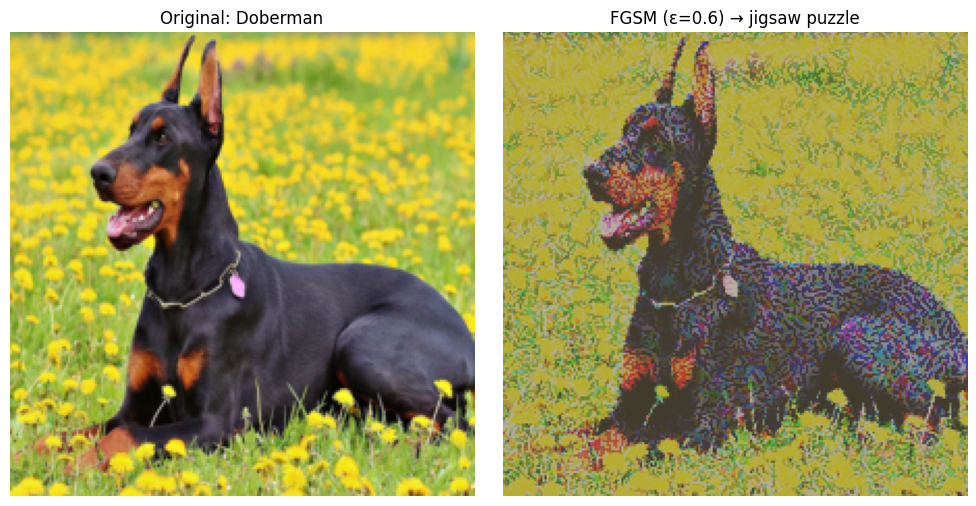

In [17]:
def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return torch.clamp(t * std + mean, -1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(denormalize(input_tensor.squeeze()).permute(1, 2, 0).numpy())
axs[0].set_title(f"Original: {labels[orig_idx]}")
axs[0].axis('off')

axs[1].imshow(denormalize(adv_image.squeeze()).permute(1, 2, 0).detach().numpy())
axs[1].set_title(f"FGSM (ε={epsilon}) → {labels[adv_idx]}")
axs[1].axis('off')
plt.tight_layout()
plt.show()


So, if we take larger epsiion we get bigger changes to each pixel.

The adversarial image looks  more visibly distorted and noisy. The model is more likely to misclassify because it’s being pushed farther from the correct decision boundary. FGSM is a single-step attack, so it benefits a lot from higher epsilion — but risks losing visual similarity. Also the classification make a prediction quite unlike the original image.

If in case of epsilin = 0.09, we get another dog classification, here we get a label that has nothing to do with a doberman.

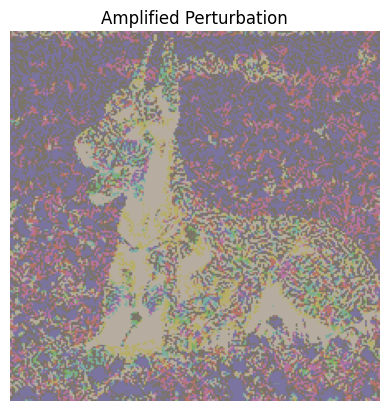

In [18]:
amplified = (adv_image - input_tensor) * 10
visual = torch.clamp(input_tensor + amplified, 0, 1)
visual = denormalize(visual.squeeze())

plt.imshow(visual.permute(1, 2, 0).detach().cpu().numpy())
plt.title("Amplified Perturbation")
plt.axis('off')
plt.show()


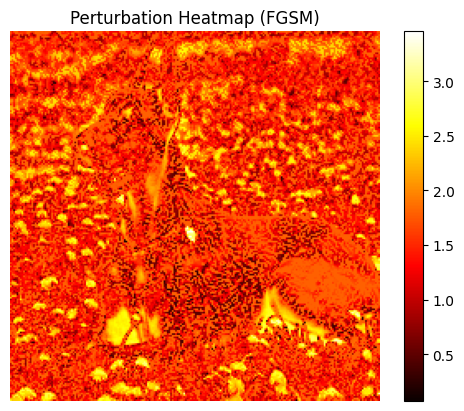

In [19]:
diff = (adv_image - input_tensor).squeeze().abs().sum(0)
plt.imshow(diff.cpu().detach().numpy(), cmap='hot')
plt.title("Perturbation Heatmap (FGSM)")
plt.axis('off')
plt.colorbar()
plt.show()


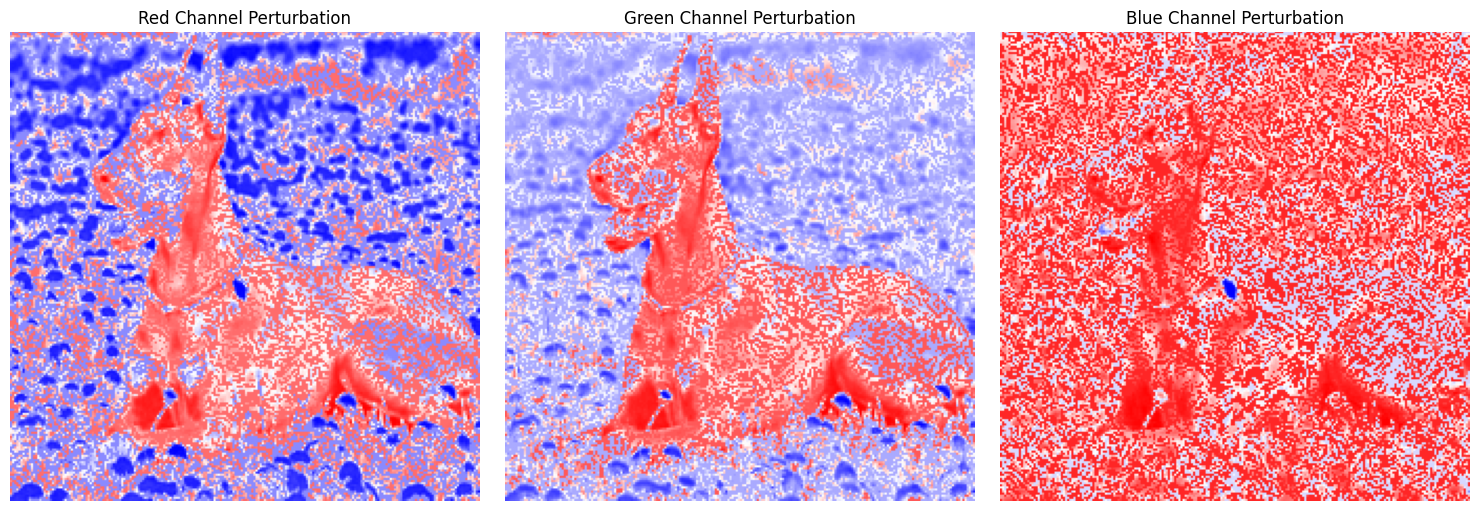

In [20]:
diff_normalized = (adv_image - input_tensor).squeeze().detach()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    axs[i].imshow(diff_normalized[i].cpu().numpy(), cmap='bwr')
    axs[i].set_title(f'{color} Channel Perturbation')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# Gradient magnitude map

Shows which parts of the image most influenced the model's prediction.
Useful for understanding model behavior; attack often targets these high-sensitivity areas.

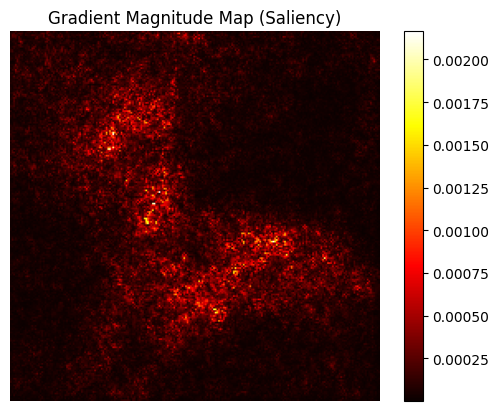

In [21]:
input_tensor.requires_grad = True
output = model(input_tensor)
loss = nn.CrossEntropyLoss()(output, torch.tensor([orig_idx], device=input_tensor.device))
model.zero_grad()
loss.backward()

grad = input_tensor.grad.squeeze().abs()
saliency, _ = torch.max(grad, dim=0)

plt.imshow(saliency.cpu().numpy(), cmap='hot')
plt.title("Gradient Magnitude Map (Saliency)")
plt.axis('off')
plt.colorbar()
plt.show()
